# **Unsmoothing of linear time series**

Let's first import different dependencies and the data:

In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

In [4]:
alternative_data_raw = pd.read_excel('EnsaeAlternativeTimeSeries.xlsx', sheet_name='Alternative Asset', index_col=0)
alternative_data_raw.tail(10)

,Commodity - USD Unhedged,Global Property USD Unhedged,Hedge Fund DJ - USD Unhedged,Infrastructure Debt - USD Unhedged,Infrastructure Equity Listed - USD Unhedged,Infrastructure Equity USD Unhedged,Nature Capital - USD Hedged,Private Equity USD Unhedged,UK Property Direct - USD Unhedged
QUARTER,,,,,,,,,
2021-Q2,201.8662,6229.774805,711.43,2534.95,NaN,275.181583,1443.470642,4691.699,278.205508
2021-Q3,215.1673,6184.521678,719.91,2544.31,NaN,271.066062,1515.657205,4897.288,280.913387
2021-Q4,211.8033,6825.772548,726.66,2535.15,6096.56,300.214659,1606.789837,5397.431,305.081135
2022-Q1,265.9137,6568.538826,742.17,2386.29,6552.00,293.265256,1777.360304,4770.109,290.587837
2022-Q2,250.8549,5436.569419,725.12,2267.73,6065.58,263.147689,1890.893920,3612.590,236.794741
2022-Q3,240.5519,4817.520307,727.68,2122.80,5481.12,226.816903,1960.578024,3274.373,187.833995
2022-Q4,245.8892,5159.896609,733.63,2173.62,6086.01,258.409265,2023.095816,3719.178,210.098219
2023-Q1,232.7065,5213.347074,735.54,2241.04,6325.68,250.338364,2026.152916,3976.480,214.263907
2023-Q2,226.7436,5241.647937,748.09,2248.24,6318.26,241.619726,NaN,4311.668,211.147599


# **I. Data Analysis**
## A : Preprocessing

In [6]:
def tweak_alternative_data(df_):
    return (df_.assign(**{col + '_%y/y': df_[col].pct_change(fill_method = None) for col in df_.columns}) #Adding the returs
            .set_index(pd.to_datetime(df_.index)) #Changing the index format to datetime
            .rename(lambda c: c.replace(' ','_'), axis = 1)) # Replacing the spaces by _ in the names


alternative_data = tweak_alternative_data(alternative_data_raw)
alternative_data.tail(10)

/tmp/ipykernel_3206/2713308186.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  .set_index(pd.to_datetime(df_.index)) #Changing the index format to datetime


,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_Listed_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged,Commodity_-_USD_Unhedged_%y/y,Global_Property_USD_Unhedged_%y/y,Hedge_Fund_DJ_-_USD_Unhedged_%y/y,Infrastructure_Debt_-_USD_Unhedged_%y/y,Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y,Infrastructure_Equity_USD_Unhedged_%y/y,Nature_Capital_-_USD_Hedged_%y/y,Private_Equity_USD_Unhedged_%y/y,UK_Property_Direct_-_USD_Unhedged_%y/y
QUARTER,,,,,,,,,,,,,,,,,,
2021-04-01,201.8662,6229.774805,711.43,2534.95,NaN,275.181583,1443.470642,4691.699,278.205508,0.133047,0.094214,0.030222,0.020519,NaN,0.017745,0.111440,0.167016,0.056565
2021-07-01,215.1673,6184.521678,719.91,2544.31,NaN,271.066062,1515.657205,4897.288,280.913387,0.065891,-0.007264,0.011920,0.003692,NaN,-0.014956,0.050009,0.043820,0.009733
2021-10-01,211.8033,6825.772548,726.66,2535.15,6096.56,300.214659,1606.789837,5397.431,305.081135,-0.015634,0.103686,0.009376,-0.003600,NaN,0.107533,0.060127,0.102127,0.086033
2022-01-01,265.9137,6568.538826,742.17,2386.29,6552.00,293.265256,1777.360304,4770.109,290.587837,0.255475,-0.037686,0.021344,-0.058718,0.074704,-0.023148,0.106156,-0.116226,-0.047506
2022-04-01,250.8549,5436.569419,725.12,2267.73,6065.58,263.147689,1890.893920,3612.590,236.794741,-0.056630,-0.172332,-0.022973,-0.049684,-0.074240,-0.102697,0.063878,-0.242661,-0.185118
2022-07-01,240.5519,4817.520307,727.68,2122.80,5481.12,226.816903,1960.578024,3274.373,187.833995,-0.041072,-0.113868,0.003530,-0.063910,-0.096357,-0.138062,0.036852,-0.093622,-0.206764
2022-10-01,245.8892,5159.896609,733.63,2173.62,6086.01,258.409265,2023.095816,3719.178,210.098219,0.022188,0.071069,0.008177,0.023940,0.110359,0.139286,0.031887,0.135844,0.118531
2023-01-01,232.7065,5213.347074,735.54,2241.04,6325.68,250.338364,2026.152916,3976.480,214.263907,-0.053612,0.010359,0.002603,0.031017,0.039380,-0.031233,0.001511,0.069182,0.019827
2023-04-01,226.7436,5241.647937,748.09,2248.24,6318.26,241.619726,NaN,4311.668,211.147599,-0.025624,0.005429,0.017062,0.003213,-0.001173,-0.034827,NaN,0.084293,-0.014544


##  B: Data Visualisation

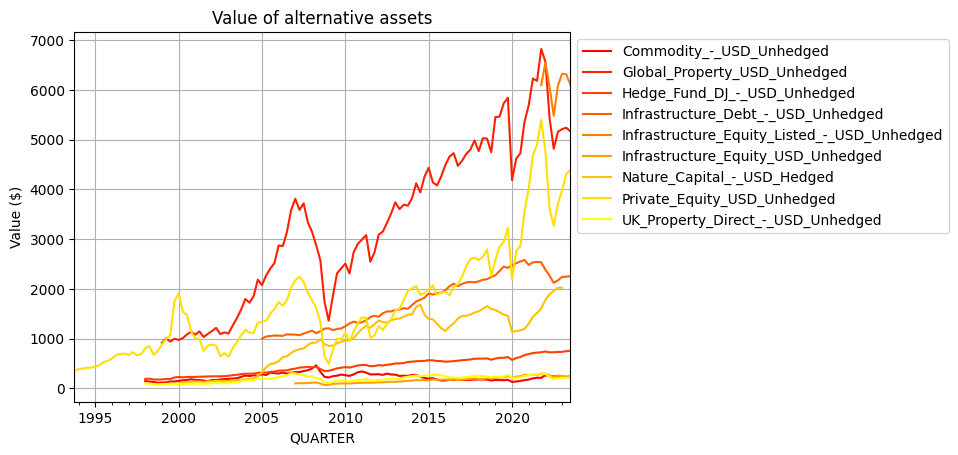

In [15]:
(alternative_data.iloc[:,0:9]
.plot(cmap = 'autumn',grid=True,ylabel='Value ($)', title='Value of alternative assets')
.legend(bbox_to_anchor = (1,1)))

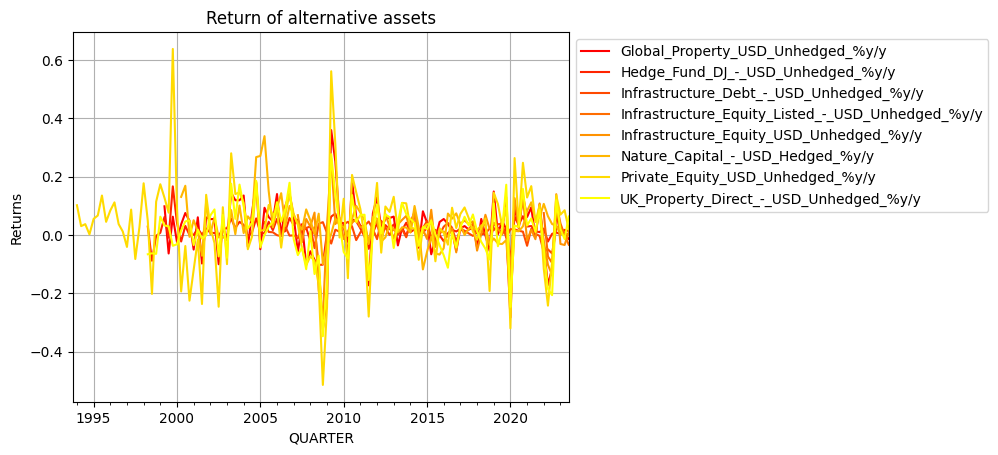

In [12]:
(alternative_data.iloc[:,10:]
.plot(cmap = 'autumn',grid=True,ylabel='Returns', title='Return of alternative assets')
.legend(bbox_to_anchor = (1,1)))

## C: Stationarity analysis 

In [76]:
unit_test = {name: (adfuller(alternative_data[name].dropna())[0], adfuller(alternative_data[name].dropna())[1]) 
       for name in alternative_data.iloc[:,10:].columns}

(pd.DataFrame(unit_test, index = ['value','p-value']).T.style.format(precision = 2)
.background_gradient(cmap = 'autumn'))

,value,p-value
Global_Property_USD_Unhedged_%y/y,-8.58,0.00
Hedge_Fund_DJ_-_USD_Unhedged_%y/y,-8.99,0.00
Infrastructure_Debt_-_USD_Unhedged_%y/y,-7.14,0.00
Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y,-2.62,0.09
Infrastructure_Equity_USD_Unhedged_%y/y,-8.06,0.00
Nature_Capital_-_USD_Hedged_%y/y,-5.63,0.00
Private_Equity_USD_Unhedged_%y/y,-9.30,0.00
UK_Property_Direct_-_USD_Unhedged_%y/y,-8.59,0.00


/home/perann/miniconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/perann/miniconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/perann/miniconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


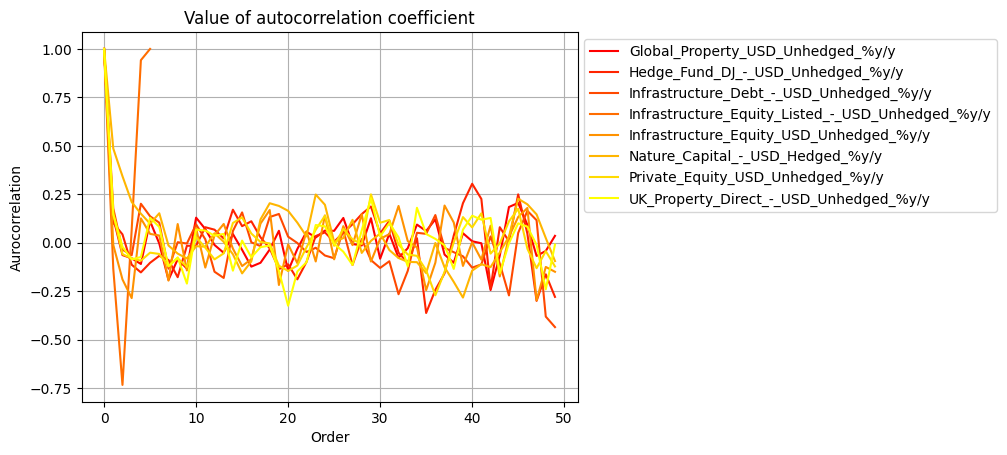

In [59]:
serial_correlation = pd.DataFrame({name:  [alternative_data[name].dropna().autocorr(k) for k in range (50)]
                       for name in alternative_data.iloc[:,10:].columns})

(serial_correlation
.plot(grid = True, cmap  = 'autumn', xlabel='Order', ylabel ='Aurocorrelation', title = 'Value of autocorrelation coefficient' )
.legend(bbox_to_anchor = (1,1)))

# **II. Autoregressive method**

## **III. Getmansky, Lo Model**